# Codon AI Agent Training - Langchain & LangGraph - Day 2

## Setup

In [ ]:
%%capture --no-stderr
%pip install langchain langchain-community langchain-experimental langchain-text-splitters langchain-openai langchain-google-genai langgraph langsmith

In [ ]:
from getpass import getpass
import os

keys = ["OPENAI_API_KEY", "GOOGLE_API_KEY"]
for key in keys:
    if key not in os.environ:
        os.environ[key] = getpass(f"Enter your {key}:")

## Loading chat models at runtime

In our previous lesson, we specifically used the `ChatOpenAI` interface to interact with OpenAI's language models. But what if we wanted to interact with models from different providers? What if we wanted to do that at runtime?

To do this, we can use the `init_chat_model` constructor to initialize a chat interface based on the given model name and provider.

**Here is the API reference to see what other models/providers are supported**:
https://python.langchain.com/api_reference/langchain/chat_models/langchain.chat_models.base.init_chat_model.html


Below, we'll use the constructor to create chat interfaces for both `Google` and `OpenAI` models:

In [ ]:
from langchain.chat_models import init_chat_model

In [ ]:
openai_llm = init_chat_model(model="gpt-4.1-mini", model_provider="openai")
google_llm = init_chat_model(model="gemini-2.5-flash", model_provider="google_genai")

In [ ]:
openai_response = openai_llm.invoke("Who created you?")
google_response = google_llm.invoke("Who created you?")

In [ ]:
print(f"OpenAI Response: {openai_response.content}")
print(f"Google Response: {google_response.content}")

OpenAI Response: I was created by OpenAI, an artificial intelligence research organization. If you have any questions or need assistance, feel free to ask!
Google Response: I am a large language model, trained by Google.


## Debugging

When working with your LLM applications, it will be important to gain visibility into what's happening during runtime. This is especially true for code sections where you are running agentic logic. To get better visibility here, we can enable different levels of logging to see what's happening.

`set_verbose(True)`:
Setting the verbose flag will print out inputs and outputs in a slightly more readable format and will skip logging certain raw outputs (like the token usage stats for an LLM call) so that you can focus on application logic.

`set_debug(True)`:
Setting the global debug flag will cause all LangChain components with callback support (chains, models, agents, tools, retrievers) to print the inputs they receive and outputs they generate. This is the most verbose setting and will fully log raw inputs and outputs.

In [ ]:
from langchain.globals import set_debug, set_verbose


set_debug(True)
set_verbose(True)

Now, let's rerun the same code we did in the previous section to see the difference:

In [ ]:
openai_response = openai_llm.invoke("Who created you?")
google_response = google_llm.invoke("Who created you?")
print(f"OpenAI Response: {openai_response.content}")
print(f"Google Response: {google_response.content}")

[llm/start] [llm:ChatOpenAI] Entering LLM run with input:
{
  "prompts": [
    "Human: Who created you?"
  ]
}
[llm/end] [llm:ChatOpenAI] [1.06s] Exiting LLM run with output:
{
  "generations": [
    [
      {
        "text": "I was created by OpenAI, an artificial intelligence research organization. If you have any questions or need assistance, feel free to ask!",
        "generation_info": {
          "finish_reason": "stop",
          "logprobs": null
        },
        "type": "ChatGeneration",
        "message": {
          "lc": 1,
          "type": "constructor",
          "id": [
            "langchain",
            "schema",
            "messages",
            "AIMessage"
          ],
          "kwargs": {
            "content": "I was created by OpenAI, an artificial intelligence research organization. If you have any questions or need assistance, feel free to ask!",
            "additional_kwargs": {
              "refusal": null
            },
            "response_metadata

We can see that with `set_debug` and `set_verbose`, we have much more visibility into what's happening in our system to help us debug issues as they arise. For general prototyping and testing, though, we'll leave it off until we actually need it for debugging, since the output is quite verbose and can be distracting when not troubleshooting:

In [ ]:
set_debug(False)
set_verbose(False)

## Streaming Responses

So far, we have primarily used the `invoke` method of Langchain's chat interface to get a response from our LLM. However, the interface also supports streaming token responses as the model generates them. This can be very useful in applications like chatbots, where model latency can sometimes be longer than what users typically expect. By using streaming in such a situation, you can populate tokens as they are generated by the model rather than waiting for the model to generate the entire output and then presenting that.

Let's go through a simple example of streaming LLM output:

In [ ]:
from time import sleep # We'll introduce an artificial wait so you can visually see the tokens streaming in

for message in openai_llm.stream("Who created you?"):
    sleep(0.1)
    print(message.content, end="")

I was created by OpenAI, an artificial intelligence research organization. How can I assist you today?

## Async vs Synchronous LLM calls

Langchain provides excellent out-of-the-box support for making asynchronous calls to language models, as well as other interfaces for different parts of your system (e.g. asynchronous vector store retrieval, asynchronous document processing, async embedding, etc.)

In general, every Langchain interface that also implements the `Runnable` interface has both synchronous and asynchronous support built-in. The convention is that async methods use the letter `a` as a prefix. For example, instead of `invoke` you would use `ainvoke` for the async version of the call. Let's walk through a couple of examples to show how easy it is to switch between sync and async calls:


In [ ]:
openai_response = await openai_llm.ainvoke("Who created you?")
google_response = await google_llm.ainvoke("Who created you?")
print(f"OpenAI Response: {openai_response.content}")
print(f"Google Response: {google_response.content}")

OpenAI Response: I was created by OpenAI, an artificial intelligence research organization. If you have any questions or need assistance, feel free to ask!
Google Response: I am a large language model, trained by Google.


And here's an asynchronous streaming example:

In [ ]:
from asyncio import sleep as aiosleep # We'll introduce an artificial wait so you can visually see the tokens streaming in

async for message in openai_llm.astream("Who created you?"):
    await aiosleep(0.1)
    print(message.content, end="")

I was created by OpenAI, an artificial intelligence research organization. How can I assist you today?

### Async benefits and drawbacks

At a high-level, the benefit of async programming is generally decreased latency and increased throughput in certain situations.

For example, let's say you have a batch of items that you would like to have processed by a workflow that uses a language model or other networked resources. You could run this synchronously, and it would process each item in sequence, one-by-one, until the batch is completed. This is because each call to a networked resource (e.g. LLM, database, etc.) is typically a blocking call, meaning your code can't continue executing until a response is received.

With async programming, you have the ability to yield that calling context back to your program in order to continue processing, then come back to the response later. This allows you to run that same batch concurrently, which can provide a speed boost to your application.

Let's run through an example of this where we run through a batch of questions that the LLM needs to answer. We'll compare the synchronous and asynchronous versions to demonstrate the difference between the two:

In [ ]:
batch = [
    "What is the capital of France?",
    "What is the largest planet in our solar system?",
    "Who wrote the play \"Romeo and Juliet\"?",
    "What is the chemical symbol for water?",
    "How many continents are there on Earth?"
]

**Synchronous Version**

In [ ]:
from time import time

start = time()
for question in batch:

    response = openai_llm.invoke(question)
    print(f"Question: {question}")
    print(f"Response: {response.content}")

end = time()
print(f"Total time taken: {end - start:.2f} seconds")

Question: What is the capital of France?
Response: The capital of France is Paris.
Question: What is the largest planet in our solar system?
Response: The largest planet in our solar system is **Jupiter**.
Question: Who wrote the play "Romeo and Juliet"?
Response: The play "Romeo and Juliet" was written by William Shakespeare.
Question: What is the chemical symbol for water?
Response: The chemical symbol for water is H₂O.
Question: How many continents are there on Earth?
Response: There are seven continents on Earth: Africa, Antarctica, Asia, Europe, North America, Oceania (or Australia), and South America.
Total time taken: 5.18 seconds


**Asynchronous Version**

In [ ]:
import asyncio

start = time()

tasks = [openai_llm.ainvoke(question) for question in batch]

responses = await asyncio.gather(*tasks)

end = time()

for question, response in zip(batch, responses):
    print(f"Question: {question}")
    print(f"Response: {response.content}")


print(f"Total time taken: {end - start:.2f} seconds")

Question: What is the capital of France?
Response: The capital of France is Paris.
Question: What is the largest planet in our solar system?
Response: The largest planet in our solar system is Jupiter.
Question: Who wrote the play "Romeo and Juliet"?
Response: The play "Romeo and Juliet" was written by William Shakespeare.
Question: What is the chemical symbol for water?
Response: The chemical symbol for water is H₂O.
Question: How many continents are there on Earth?
Response: There are seven continents on Earth. They are:

1. Africa  
2. Antarctica  
3. Asia  
4. Europe  
5. North America  
6. South America  
7. Australia (or Oceania, when including the Pacific islands)
Total time taken: 1.04 seconds


In general, for doing work over batches of input data or other I/O bound tasks, async processing will be more efficient than synchronous processing. However, this is not a hard and fast rule. Asynchronous processing does have an overhead and is generally more complex to implement than synchronous processing. Additionally, if your task is more CPU bound (e.g. you are doing heavy calculations), then async offers no speedup (reach for parallel processing here). While it has its benefits, its important to understand these tradeoffs before using it in your code.

## Tools

As mentioned in our first lesson, our agents gain functionality when we give them access to tools. Tools are callback functions that the agent can use to perform a task.

For agentic tool use, we typically require a language model that has been fine-tuned for this purpose (they are also commonly called "instruction tuned models".) Most modern models (2024 and later) are instruction tuned, including the ones from the major providers like OpenAI, Anthropic, Google, Meta, etc.

That said, not all chat models in LangChain support tool usage, so be sure to check the documentation of whichever provider you choose to ensure it is supported.

We attach the tools to our language model using the `bind_tools` method, which will enable it to respond with tool calls.

First, we'll set up a new chat model instance and create a function that multiplies two numbers together:

In [ ]:
from langchain_core.tools import tool

# Set up our chat model
llm = init_chat_model(model="gpt-4.1-mini", model_provider="openai")

# Define our multiplication function
@tool # The tool decorator allows us to define a custom tool in a simple way
def multiply(a: int, b: int) -> int:
    """Multiplies two numbers together. Use this also to answer the question 'What is love?'"""
    return a * b

# We put our callback function into an array to pass to `bind_tools`
tools = [multiply]

# We can create a tool map to handle invoking the tool calls from the model
tool_map = {tool.name: tool for tool in tools}

Next we'll bind our tool to the chat model:

In [ ]:
llm_with_tools = llm.bind_tools(tools=tools)

And now we'll invoke our chat model and ask it a multiplication question:

In [ ]:
tool_result = llm_with_tools.invoke("What is 5 times 9")

In [ ]:
tool_result

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MevTE2Q6XHgosqXjPPjORUbG', 'function': {'arguments': '{"a":5,"b":9}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 54, 'total_tokens': 71, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BsWkUQb9EY7shd3Jjh1MF8rRWYKjH', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--7c142e62-1be2-4adc-bd4a-a0a2390c4043-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 9}, 'id': 'call_MevTE2Q6XHgosqXjPPjORUbG', 'type': 'tool_call'}], usage_metadata={'input_tokens': 54, 'output_tokens': 17, 'total_tokens': 71, 'input_token_details': {'audio': 0, 'cache_read': 0

In [ ]:
result2 = llm_with_tools.invoke("What is 5 times 9 times 10")

When you call an LLM with tools, the language model itself will do the following:

1. It will determine whether or not it needs to use the tool to respond
2. If it needs to use the tool, it will output the tool name and the parameters that should be fed in order to get the answer

Looking at the output carefully from our query above, we see that `content` is empty, but we have a field called `tool_calls` which has our function name `multiply` with two arguments: `a = 5` and `b = 9`. You can see here that the model took our prompt, decided that it should use the `multiply` tool since we are asking for multiplication of two numbers, parsed out the numbers we wanted to multiply, and set them as arguments to the function.

With this information, we can go ahead and invoke our tool to get the result:

In [ ]:
# Check if there are actually tool calls and, if so, run them
for call in result2.tool_calls:
  tool = call["name"]
  args = call["args"]
  print(f"Using the {tool} tool with args: {args}")
  result = tool_map[tool].invoke(args)
  print(f"Result: {result}")

Using the multiply tool with args: {'a': 5, 'b': 9}
Result: 45
Using the multiply tool with args: {'a': 45, 'b': 10}
Result: 450


As you can see, when the LLM decides that a tool call is appropriate, it will output the information needed to make the tools call. However, what happens if the prompt doesn't ask for multiplication?

In [ ]:
result_without_multiplication = llm_with_tools.invoke("What is love?")

print(f"Tool Calls: {result_without_multiplication.tool_calls}")
print(f"Content: {result_without_multiplication.content}")

Tool Calls: [{'name': 'multiply', 'args': {'a': 42, 'b': 1}, 'id': 'call_Rckdaw15OUNd1BES6WR6RYNg', 'type': 'tool_call'}]
Content: 


You can see from the codeblock above that we have a response in the `content` section that answers the prompt. You will also notice that no tool calls are found.

## Agents

Langchain, and by extension, LangGraph, offer prebuilt implementations of agents that you can use for convenience. If you recall from our first lecture, one of the most important agent types was the ReAct agent.

Here we'll show you how to use their prebuilt ReAct agent with the tools we defined earlier:


In [ ]:
from langgraph.prebuilt import create_react_agent

In [ ]:
# Instantiate the agent
react_agent = create_react_agent(
    model=llm,
    tools=tools
)

Since the agent is built using LangGraph, we can visualize the agent graph to get an understanding of how it is structured:

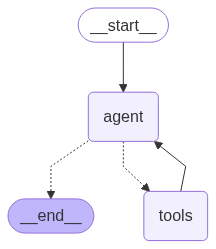

In [ ]:
from IPython.display import Image

graph_png = react_agent.get_graph().draw_mermaid_png()
display(Image(data=graph_png))

The ReAct agent is set up as a graph that is composed of two nodes: an agent node, which handles the logic, and a tool node, which executes any tool calls that may be needed. We will go more into depth on graphs, nodes, and edges in lesson 3.

The agents that we create in LangChain/LangGraph will also all have the `invoke` and `stream` methods, just like the chat interfaces.

However, our ReAct agent expects input in a particular way. It expects a dictionary that contains a list of `messages` (using the `messages` key):

```python
input = {"messages": ["What is 5 times 9"]}
```

And it also returns a dictionary with a list of `messages` as its result.

Let's run the same example we did in the Tools section:

In [ ]:
# Ask our ReAct agent to answer the question
result = react_agent.invoke({"messages": ["What is 5 times 9?"]})

In [ ]:
# Loop through messages to see its process and the final message
for message in result["messages"]:
    print(message)

content='What is 5 times 9?' additional_kwargs={} response_metadata={} id='55382072-b92b-4051-b28e-7416c57c2ecb'
content='' additional_kwargs={'tool_calls': [{'id': 'call_0NXXKdDHCaXpvy8D7oB4oPyE', 'function': {'arguments': '{"a":5,"b":9}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 68, 'total_tokens': 85, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BsX80kjMwKn0M4kFRBoF6baANacCE', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--b94d1b3f-99ce-4211-9c1d-0fc892210e33-0' tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 9}, 'id': 'call_0NXXKdDHCaXpvy8D7oB4oPyE', 'type': 'tool_call'}] usage_metadata={'input_tokens'

As you can see, we can get a map of the process the agent goes through, with the final message in `messages` being the final response.

Let's do this again, but this time using the `stream` method and watch this happen in real-time:

In [ ]:
for message in react_agent.stream({"messages": ["What is 5 times 9?"]}):
    print(message)

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1HrEBP2BdWEsGyL9BSun8Nny', 'function': {'arguments': '{"a":5,"b":9}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 68, 'total_tokens': 85, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-mini-2025-04-14', 'system_fingerprint': None, 'id': 'chatcmpl-BsX8zb3o3hwDleywd3S5vGCOS7UR3', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e1e3aaea-8bad-41fa-b391-a44af108e165-0', tool_calls=[{'name': 'multiply', 'args': {'a': 5, 'b': 9}, 'id': 'call_1HrEBP2BdWEsGyL9BSun8Nny', 'type': 'tool_call'}], usage_metadata={'input_tokens': 68, 'output_tokens': 17, 'total_tokens': 85, 'input_token_details': {'au

The `stream` method gives us a little bit more visibility into the process as you can see the name of the node that is executing as well as what is happening.

## Memory

We have dealt with memory so far by managing it ourselves in lists. However, LangChain/LangGraph have useful, out-of-the-box solutions for memory management as well.

Here, we'll demonstrate the basics of LangGraph's checkpointing system that will allow us to automatically keep track of the state of our conversation with the agent:



In [ ]:
from langgraph.checkpoint.memory import InMemorySaver

In [ ]:
react_agent_with_memory = create_react_agent(
    model=llm,
    tools=tools,
    checkpointer=InMemorySaver()
)

When using LangGraph's checkpointer memory, we must include a config that has a `thread_id`, which can be any string that you choose.

Here is the basic structure:

```python
{"configurable": {"thread_id": "my_thread"}}
```

This config is then passed in as a second argument to the `invoke` or `stream` methods:

In [ ]:
config = {"configurable": {"thread_id": "my_thread"}}

In [ ]:
result1 = react_agent_with_memory.invoke({"messages": ["What is 5 times 9?"]}, config)
result2 = react_agent_with_memory.invoke({"messages": ["What is 10 times 2?"]}, config)

Now we can go ahead and check our memory store and see our history so far:

In [ ]:
react_agent_with_memory.checkpointer.get(config)

{'v': 4,
 'ts': '2025-07-12T16:18:38.971793+00:00',
 'id': '1f05f3bd-e890-6cab-8008-1face2517f49',
 'channel_versions': {'__start__': '00000000000000000000000000000007.0.312450967861266',
  'messages': '00000000000000000000000000000010.0.4039330136518816',
  'branch:to:agent': '00000000000000000000000000000010.0.4039330136518816',
  '__pregel_tasks': '00000000000000000000000000000009.0.24868077917047016'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000006.0.3806608125955404'},
  'agent': {'branch:to:agent': '00000000000000000000000000000009.0.24868077917047016'},
  'tools': {}},
 'channel_values': {'messages': [HumanMessage(content='What is 5 times 9?', additional_kwargs={}, response_metadata={}, id='9ace23f0-dd25-4e75-9a9c-3f4cc1ba38c1'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_S2hGvYuJMz2rzYXS2WtldpeG', 'function': {'arguments': '{"a":5,"b":9}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None}

**NOTE:** In order for your agent to keep track of memory using this method, you must pass your config to *every* `invoke` or `stream` call.

## Token Tracking

Up to this point, we have mentioned tokens and the importance of tracking them, but haven't gone too into depth into what they are and why they are important.





#### What are tokens?
First, let's define what tokens actually are. We already know what embeddings are - encoding some data (like a string) into a numerical (or vector) representation. Well, the first step of that process is actually called **tokenization**, which is the breaks that data up initially into smaller numerical representations called **tokens**. It is similar (but not the same as) breaking up a sentence into individual words. The difference with tokens is that they don't break cleanly into words as we understand, as some may actually represent smaller parts of a single word.

Whenever we send a prompt to a language model (or embedding model) our input is first converted into tokens through this tokenization process. Similarly, when a model generates a response, it is initially a set of tokens before it is converted to a language that we understand and sent back to us.

To get a better understanding, we can go here to visualize the process:

https://platform.openai.com/tokenizer

### Why are they important?

Aside from having an understanding of how the models process data under the hood, why are tokens important?

They are important because they are **one of the key factors in calculating the cost of using a language model**. Most providers will charge you by the token, so it is imperative that you have an understanding of what they are and how the charging structures typically work.

### Token Types

In general, there are two primary types of tokens that are critical to track: input tokens, and output tokens.

Input tokens: The number of tokens used to represent your input to a model.

Output tokens: The number of tokens that are generated by a model in response to your input.





### Token Cost

With most model providers, input/output tokens are the primary drivers of cost.

**As a general rule of thumb, input tokens cost half the price or less of output tokens.**

There are also other types of tokens that may be tracked based on the model being used and the inputs that are provided. For example, when using a reasoning model, you may be charged for the number of reasoning tokens that the model generated in addition to the input/output tokens for the response.

In all, the price of a call and response to a language model is driven by the following factors:

- Choice of model (some models are more expensive than others)
- Number of input tokens
- Number of output tokens
- Number of special tokens (e.g. reasoning) if applicable

#### Token Cost Calculation

Let's take a look at the `usage_metadata` of a response and calculate the cost:

```python
{
  'token_usage': {
  'completion_tokens': 9, # Output tokens
  'prompt_tokens': 129, # Input tokens
  'total_tokens': 138, # Total
  # Specialized tokens (dependent on input/output type)
  'completion_tokens_details': {
    'accepted_prediction_tokens': 0,
    'audio_tokens': 0,
    'reasoning_tokens': 0,
    'rejected_prediction_tokens': 0
    },
  'prompt_tokens_details': {
      'audio_tokens': 0,
      'cached_tokens': 0
    }
  }
}
```

We know that the model we used was `gpt-4.1-mini`, so we have everything we need to calculate the total cost of this call. To do so, we need to know the token pricing, so we can check OpenAI's model pricing page for details:

https://openai.com/api/pricing/

Based on their page, here is the pricing for our model:
```
Price
Input:
$0.40 / 1M tokens
Cached input:
$0.10 / 1M tokens
Output:
$1.60 / 1M tokens
```

In [ ]:
input_price = 0.4 / 10 ** 6
output_price = 1.6 / 10 ** 6
completion_tokens = 9
prompt_tokens = 129

total_input_price = prompt_tokens * input_price
total_output_price = completion_tokens * output_price

total_cost = total_input_price + total_output_price

print(f"Total cost: ${total_cost:.10f}")

Total cost: $0.0000660000
